# Notebook for running experiments with OpenAI models


In [1]:
import pandas as pd
import numpy as np
from openai import OpenAI
from dotenv import load_dotenv # pip install python-dotenv
load_dotenv()   # Set API KEY values from .env file


True

In [2]:
dataset = pd.read_csv("data/ipcc_statements_dataset_original_cleaned_context.csv")
test_set = dataset[dataset["split"]=="test"].copy()
train_set = dataset[dataset["split"]=="train"].copy()


In [3]:
test_set.head()

,Unnamed: 0.1,Unnamed: 0,statement_idx,report,page_num,sent_num,original_statement,final_statement,confidence,score,split,context,has_confidence_in_final_statement
3,3,0,3,AR6_WGI,24,2,"Since 1750, increases in CO 2 (47%) and CH 4 (...","Since 1750, increases in CO2 (47%) and CH4 (15...",very high,3,test,Estimates account for both direct emissions in...,False
42,42,1,42,AR6_WGI,37,16,"Over the next 2000 years, global mean sea leve...","Over the next 2000 years, global mean sea leve...",low,0,test,Continued ice loss over the 21st century is vi...,False
77,77,2,77,AR6_WGI,47,7,"By the end of the century, scenarios with very...","By the end of the century, scenarios with very...",high,2,test,"{6.6, 6.7, Box TS.7}. D.2.3 Scenarios with ver...",False
81,81,3,81,AR6_WGI,62,2,"Over the past millennium, and especially since...","Over the past millennium, and especially since...",medium,1,test,"{1.3.2, 1.5.1, Cross-Chapter Boxes 2.1 and 2.4...",False
86,86,4,86,AR6_WGI,63,8,This paleo context supports the assessment tha...,The paleo context supports the assessment that...,high,2,test,"For example, under a past global warming level...",False


## Define Prompt

Currently uses the same prompt for zero-shot experiments as from the original workshop paper, but we can try tuning/adjusting, maybe with DSPy.

In [4]:
def get_original_prompt(statement):
    return f"""
You are a knowledgeable climate science assistant trained to assess the confidence level associated with various statements about climate change.       

You will be presented with a statement about climate science, climate impacts or climate change mitigation which is retrieved or paraphrased from the IPCC AR6 WGI, WGII or WGIII assessment reports. Climate scientists have evaluated that statement as low confidence, medium confidence, high confidence, or very high confidence, based on evidence (type, amount, quantity, consistency) and agreement among their peers. What is their confidence level?        

Respond *only* with one of the following words: 'low', 'medium', 'high', 'very high'. If you don't know, you can respond 'I don't know'.

---

Follow the following format.

Statement: ${{a short statement about climate.}}
Confidence: ${{must be *only*: 'low', 'medium', 'high', 'very high'}}

---
Statement: {statement}
Confidence: """

In [5]:
def get_refined_prompt(statement):
    return f"""
You are a helpful and knowledgeable climate science and policy assistant trained to assess human expert confidence in statements about climate change.

You will be presented with a sentence about climate science, the impacts of climate change, or mitigation of climate change, retrieved or paraphrased from the 6th IPCC assessment report. 

This statement has been labeled as low, medium, high, or very high confidence by a consensus of climate experts, based on the type, quality, quantity, and consistency of scientific evidence available.

Respond *only* with one of the following words: 'low', 'medium', 'high', 'very high'.

Statement: {statement}
Confidence: """

## Choose Model

In [6]:
client = OpenAI()
model = "gpt-3.5-turbo"

## Helper Functions for running experiments

In [7]:
import re
# Get a normalized classification string from the model's raw response
def extract_confidence(text):
    if re.search(r"low", text, re.IGNORECASE):
        return "low"
    elif re.search(r"medium", text, re.IGNORECASE):
        return "medium"
    elif re.search(r"very high", text, re.IGNORECASE):
        return "very high"
    elif re.search(r"high", text, re.IGNORECASE):
        return "high"
    elif re.search(r"i don't know", text, re.IGNORECASE):
        return "idk"
    else:
        return "N/A"

In [8]:
import numpy as np 

# Prompt the model and get raw response, normalized response, logprobs
def query_openai_model(client, statement, prompt_fn, model): 
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "user", "content": prompt_fn(statement)}
            ],
            temperature=0, 
            logprobs=True,
            top_logprobs=5
        )
    raw_output = response.choices[0].message.content
    cleaned_output = extract_confidence(raw_output)
    top_logprobs = response.choices[0].logprobs.content[0].top_logprobs
    logprobs = [(logprob.token, logprob.logprob, np.round(np.exp(logprob.logprob)*100,2)) for logprob in top_logprobs]
    return pd.Series([raw_output, cleaned_output, logprobs])

In [9]:
# Query the model. n_sc = number of times to run the experiment, for self-consistency.
def run_experiment(dataset, n_sc, prompt_fn, model):
    for i in range(1, n_sc+1):
        dataset[[f"raw_output_{i}", f"model_confidence_classification_{i}", f"model_logprobs{i}"]] = dataset["final_statement"].apply(lambda x: query_openai_model(client, x, prompt_fn, model))
    return dataset
                                                                                                                   

In [10]:
original_prompt_experiment_df = test_set.copy()
original_prompt_experiment_df = run_experiment(original_prompt_experiment_df, 5, get_original_prompt, model) 

/var/folders/zw/vnb4lkhd14n9cx0d71_qh_z00000gn/T/ipykernel_21596/250015384.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[[f"raw_output_{i}", f"model_confidence_classification_{i}", f"model_logprobs{i}"]] = dataset["final_statement"].apply(lambda x: query_openai_model(client, x, prompt_fn, model))
/var/folders/zw/vnb4lkhd14n9cx0d71_qh_z00000gn/T/ipykernel_21596/250015384.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[[f"raw_output_{i}", f"model_confidence_classification_{i}", f"mod

## Run experiments

In [11]:
original_prompt_experiment_df.head()

,Unnamed: 0.1,Unnamed: 0,statement_idx,report,page_num,sent_num,original_statement,final_statement,confidence,score,...,model_logprobs2,raw_output_3,model_confidence_classification_3,model_logprobs3,raw_output_4,model_confidence_classification_4,model_logprobs4,raw_output_5,model_confidence_classification_5,model_logprobs5
3,3,0,3,AR6_WGI,24,2,"Since 1750, increases in CO 2 (47%) and CH 4 (...","Since 1750, increases in CO2 (47%) and CH4 (15...",very high,3,...,"[(high, -0.41188926, 66.24), (very, -1.870662,...",high,high,"[(high, -0.43733278, 64.58), (very, -1.1386877...",high,high,"[(high, -0.41188926, 66.24), (very, -1.870662,...",high,high,"[(high, -0.5610231, 57.06), (very, -1.4351782,..."
42,42,1,42,AR6_WGI,37,16,"Over the next 2000 years, global mean sea leve...","Over the next 2000 years, global mean sea leve...",low,0,...,"[(high, -0.78988725, 45.39), (High, -1.1020439...",high,high,"[(high, -0.25062624, 77.83), (medium, -2.33270...",high,high,"[(high, -0.26605052, 76.64), (medium, -2.04884...",high,high,"[(high, -0.26397765, 76.8), (medium, -2.409083..."
77,77,2,77,AR6_WGI,47,7,"By the end of the century, scenarios with very...","By the end of the century, scenarios with very...",high,2,...,"[(high, -0.07486023, 92.79), (High, -3.32038, ...",high,high,"[(high, -0.07878128, 92.42), (High, -3.186907,...",high,high,"[(high, -0.17241313, 84.16), (High, -2.141514,...",high,high,"[(high, -0.17241313, 84.16), (High, -2.141514,..."
81,81,3,81,AR6_WGI,62,2,"Over the past millennium, and especially since...","Over the past millennium, and especially since...",medium,1,...,"[(High, -0.8193635, 44.07), (high, -1.3651704,...",High,high,"[(High, -0.8193635, 44.07), (high, -1.3651704,...",High,high,"[(High, -0.61814904, 53.89), (Medium, -0.97612...",High,high,"[(High, -0.6578959, 51.79), (high, -1.5878752,..."
86,86,4,86,AR6_WGI,63,8,This paleo context supports the assessment tha...,The paleo context supports the assessment that...,high,2,...,"[(High, -0.36061427, 69.72), (high, -1.4423823...",High,high,"[(High, -0.08345645, 91.99), (Medium, -2.99786...",High,high,"[(High, -0.6589198, 51.74), (high, -0.88481855...",High,high,"[(High, -0.1118922, 89.41), (high, -2.6632056,..."


In [12]:
original_prompt_experiment_df.to_csv("results/cleaned_dataset/gpt_3.5_turbo_sc_original_prompt_03062024.csv")

In [13]:
manually_adjusted_prompt_experiment_df = test_set.copy()
manually_adjusted_prompt_experiment_df = run_experiment(manually_adjusted_prompt_experiment_df, 5, get_refined_prompt, model) 

/var/folders/zw/vnb4lkhd14n9cx0d71_qh_z00000gn/T/ipykernel_21596/250015384.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[[f"raw_output_{i}", f"model_confidence_classification_{i}", f"model_logprobs{i}"]] = dataset["final_statement"].apply(lambda x: query_openai_model(client, x, prompt_fn, model))


In [14]:
manually_adjusted_prompt_experiment_df.head()


,Unnamed: 0.1,Unnamed: 0,statement_idx,report,page_num,sent_num,original_statement,final_statement,confidence,score,...,model_logprobs2,raw_output_3,model_confidence_classification_3,model_logprobs3,raw_output_4,model_confidence_classification_4,model_logprobs4,raw_output_5,model_confidence_classification_5,model_logprobs5
3,3,0,3,AR6_WGI,24,2,"Since 1750, increases in CO 2 (47%) and CH 4 (...","Since 1750, increases in CO2 (47%) and CH4 (15...",very high,3,...,"[(very, -0.391128, 67.63), (high, -1.5106597, ...",very high,very high,"[(very, -0.59667784, 55.06), (high, -1.122469,...",very high,very high,"[(very, -0.32500747, 72.25), (high, -1.3966112...",very high,very high,"[(very, -0.63954633, 52.75), (high, -1.0305815..."
42,42,1,42,AR6_WGI,37,16,"Over the next 2000 years, global mean sea leve...","Over the next 2000 years, global mean sea leve...",low,0,...,"[(high, -0.42801774, 65.18), (very, -1.2220718...",high,high,"[(high, -0.4636395, 62.9), (very, -1.1558735, ...",high,high,"[(high, -0.23398975, 79.14), (very, -1.9968681...",high,high,"[(high, -0.23398975, 79.14), (very, -1.9968681..."
77,77,2,77,AR6_WGI,47,7,"By the end of the century, scenarios with very...","By the end of the century, scenarios with very...",high,2,...,"[(high, -0.057264157, 94.43), (High, -3.497783...",high,high,"[(high, -0.06281204, 93.91), (High, -3.1143773...",high,high,"[(high, -0.042196337, 95.87), (very, -3.800489...",high,high,"[(high, -0.09090794, 91.31), (High, -2.992384,..."
81,81,3,81,AR6_WGI,62,2,"Over the past millennium, and especially since...","Over the past millennium, and especially since...",medium,1,...,"[(high, -0.17940255, 83.58), (medium, -2.50715...",high,high,"[(high, -0.108506784, 89.72), (High, -3.069488...",high,high,"[(high, -0.15423928, 85.71), (medium, -2.29845...",high,high,"[(high, -0.18426313, 83.17), (medium, -2.10391..."
86,86,4,86,AR6_WGI,63,8,This paleo context supports the assessment tha...,The paleo context supports the assessment that...,high,2,...,"[(high, -0.5630718, 56.95), (High, -1.2337661,...",high,high,"[(high, -0.4157766, 65.98), (High, -1.51135, 2...",high,high,"[(high, -0.5198532, 59.46), (very, -1.5090365,...",high,high,"[(high, -0.28433055, 75.25), (very, -1.9317381..."


In [15]:
manually_adjusted_prompt_experiment_df.to_csv("results/cleaned_dataset/gpt_3.5_turbo_sc_manually_adjusted_prompt_03062024.csv")

## Analyze results

In [16]:
manually_adjusted_prompt_experiment_df = pd.read_csv("results/cleaned_dataset/gpt_3.5_turbo_sc_manually_adjusted_prompt_03062024.csv")
original_prompt_experiment_df = pd.read_csv("results/cleaned_dataset/gpt_3.5_turbo_sc_original_prompt_03062024.csv")

In [17]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report

def get_metrics(results_df, model_classification_col_name):
    true_labels = results_df.loc[(results_df[model_classification_col_name] != 'N/A') & (results_df[model_classification_col_name] != 'idk'), 'confidence']
    predicted_labels = results_df.loc[(results_df[model_classification_col_name] != 'N/A') & (results_df[model_classification_col_name] != 'idk'), model_classification_col_name]

    # Compute macro F1 score
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    print("Macro F1 score:", f1)

    # Compute weighted F1 score
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    print("Weighted F1 score:", f1)

    # Compute precision for each class
    precision = precision_score(true_labels, predicted_labels, average=None)

    # Compute recall for each class
    recall = recall_score(true_labels, predicted_labels, average=None)

    # Compute F1 score for each class
    f1 = f1_score(true_labels, predicted_labels, average=None)

    # Create a dataframe to store precision and recall for each class
    class_metrics_df = pd.DataFrame({'Precision': precision, 'Recall': recall, 'F1': f1})

    # Add labels to the class metrics dataframe
    class_metrics_df['Class'] = true_labels.unique().astype(str)

    # Sort the dataframe by class index or name
    class_metrics_df = class_metrics_df.sort_values('Class', key=lambda x: pd.Categorical(x, categories=["low", "medium", "high", "very high"]))

    # Print class metrics dataframe
    #print(class_metrics_df)

    # Compute accuracy for the whole system
    accuracy = accuracy_score(true_labels, predicted_labels)

    # Compute accuracy by class

    print("Accuracy (total):", accuracy)

    report = classification_report(true_labels, predicted_labels, digits=4)
    print(report)

    # Count classes
    category_counts = true_labels.value_counts()
    print(category_counts)



In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

def get_confidence_assessment(results_df, model_classification_col_name):
    # Filter samples
    fs = results_df.loc[(results_df[model_classification_col_name] != 'N/A') & (results_df[model_classification_col_name] != 'idk')] 

    # Compute a certainty score
    value_map = {'low': 0, 'medium': 1, 'high': 2, 'very high': 3}

    fs['predicted_score'] = fs[model_classification_col_name].apply(
        lambda x: value_map[x])

    # Break down scores
    scores_all = {
        "low": fs.loc[fs['score'] == 0, 'predicted_score'].mean(),
        "medium": fs.loc[fs['score'] == 1, 'predicted_score'].mean(),
        "high": fs.loc[fs['score'] == 2, 'predicted_score'].mean(),
        "very high": fs.loc[fs['score'] == 3, 'predicted_score'].mean()
    }

    scores_wg1 = {
        "low": fs.loc[(fs['score'] == 0) & (fs['report'] == 'AR6_WGI'), 'predicted_score'].mean(),
        "medium": fs.loc[(fs['score'] == 1) & (fs['report'] == 'AR6_WGI'), 'predicted_score'].mean(),
        "high": fs.loc[(fs['score'] == 2) & (fs['report'] == 'AR6_WGI'), 'predicted_score'].mean(),
        "very high": fs.loc[(fs['score'] == 3) & (fs['report'] == 'AR6_WGI'), 'predicted_score'].mean()
    }

    scores_wg23 = {
        "low": fs.loc[(fs['score'] == 0) & (fs['report'] != 'AR6_WGI'), 'predicted_score'].mean(),
        "medium": fs.loc[(fs['score'] == 1) & (fs['report'] != 'AR6_WGI'), 'predicted_score'].mean(),
        "high": fs.loc[(fs['score'] == 2) & (fs['report'] != 'AR6_WGI'), 'predicted_score'].mean(),
        "very high": fs.loc[(fs['score'] == 3) & (fs['report'] != 'AR6_WGI'), 'predicted_score'].mean()
    }

    print("=== All AR6 reports===")
    print(f"Average ground truth score: {results_df['score'].mean()}")
    print(f"Average predicted score: {fs['predicted_score'].mean()}")
    print(f"Average scores per category: {scores_all}\n")

    print("=== AR6 WGI report ===")
    print(f"Average ground truth score: {results_df.loc[results_df['report'] == 'AR6_WGI', 'score'].mean()}")
    print(f"Average predicted score: {fs.loc[fs['report'] == 'AR6_WGI', 'predicted_score'].mean()}")
    print(f"Average scores per category: {scores_wg1}\n")

    print("=== AR6 WGII/III reports ===")
    print(f"Average ground truth score: {results_df.loc[results_df['report'] != 'AR6_WGI', 'score'].mean()}")
    print(f"Average predicted score: {fs.loc[fs['report'] != 'AR6_WGI', 'predicted_score'].mean()}")
    print(f"Average scores per category: {scores_wg23}\n")

    # Extract labels and values from the data dictionary
    labels = list(scores_all.keys())
    values_all = list(scores_all.values())
    values_wg1 = list(scores_wg1.values())
    values_wg23 = list(scores_wg23.values())

    # Define the custom labels for the x-axis
    x_labels = ['0 (Low)', '1 (Medium)', '2 (High)', '3 (Very high)']

    # Create the line plot with labeled curve
    sns.lineplot(x=labels, y=values_all, label='Average prediction')
    sns.lineplot(x=labels, y=values_wg1, linestyle='--', color="steelblue", label='WG1 report')
    sns.lineplot(x=labels, y=values_wg23, linestyle='dotted', color="steelblue", label='WG2 & WG3 report')


    # Add the ground truth line (y = x)
    x = np.arange(len(labels))
    plt.plot(x, x, linestyle='--', color='red', label='Ground truth')

    # Customize the x-axis tick labels
    plt.xticks(labels, x_labels)

    # Set the y-axis limits
    plt.ylim(0, 3)

    # Set the title and labels
    plt.title("Average predicted certainty level per class")
    plt.xlabel("Label")
    plt.ylabel("Value")

    # Show the legend
    plt.legend()

    # Show the plot
    plt.show()

Macro F1 score: 0.25914386498328634
Weighted F1 score: 0.3325789491883738
Accuracy (total): 0.4033333333333333
              precision    recall  f1-score   support

        high     0.4522    0.5200    0.4837       100
         low     1.0000    0.0200    0.0392        50
      medium     0.3681    0.6700    0.4752       100
   very high     0.5000    0.0200    0.0385        50

    accuracy                         0.4033       300
   macro avg     0.5801    0.3075    0.2591       300
weighted avg     0.5234    0.4033    0.3326       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.3933333333333333
Average scores per category: {'low': 1.12, 'medium': 1.34, 'high': 1.52, 'very high': 1.52}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.6105263157894736
Average scores per category: {'low': 1.3, '

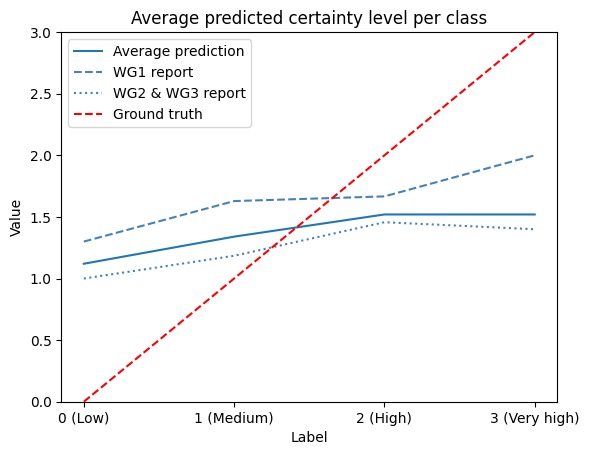

Macro F1 score: 0.24247302761423428
Weighted F1 score: 0.31688711374205597
Accuracy (total): 0.38666666666666666
              precision    recall  f1-score   support

        high     0.4587    0.5000    0.4785       100
         low     0.0000    0.0000    0.0000        50
      medium     0.3476    0.6500    0.4530       100
   very high     0.5000    0.0200    0.0385        50

    accuracy                         0.3867       300
   macro avg     0.3266    0.2925    0.2425       300
weighted avg     0.3521    0.3867    0.3169       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.37
Average scores per category: {'low': 1.12, 'medium': 1.34, 'high': 1.49, 'very high': 1.44}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.6105263157894736
Average scores per category: {'low': 1.3, 'medium': 1.6

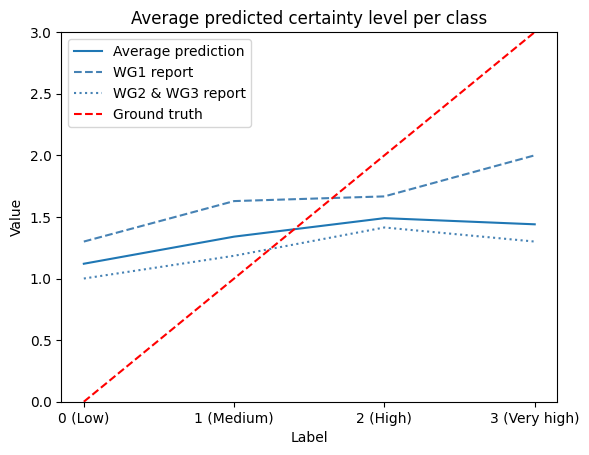

Macro F1 score: 0.2616957289482397
Weighted F1 score: 0.33598143447497825
Accuracy (total): 0.4066666666666667
              precision    recall  f1-score   support

        high     0.4727    0.5200    0.4952       100
         low     1.0000    0.0200    0.0392        50
      medium     0.3636    0.6800    0.4739       100
   very high     0.5000    0.0200    0.0385        50

    accuracy                         0.4067       300
   macro avg     0.5841    0.3100    0.2617       300
weighted avg     0.5288    0.4067    0.3360       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.3766666666666667
Average scores per category: {'low': 1.08, 'medium': 1.33, 'high': 1.52, 'very high': 1.48}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.5789473684210527
Average scores per category: {'low': 1.25, 

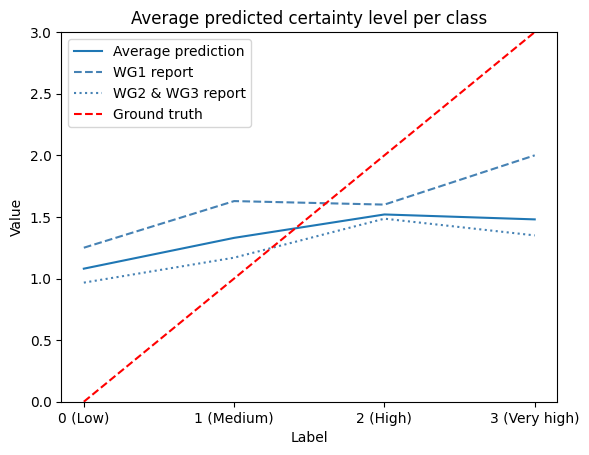

Macro F1 score: 0.24760948312632497
Weighted F1 score: 0.3173254646812538
Accuracy (total): 0.38333333333333336
              precision    recall  f1-score   support

        high     0.4348    0.5000    0.4651       100
         low     0.5000    0.0200    0.0385        50
      medium     0.3481    0.6300    0.4484       100
   very high     0.5000    0.0200    0.0385        50

    accuracy                         0.3833       300
   macro avg     0.4457    0.2925    0.2476       300
weighted avg     0.4276    0.3833    0.3173       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.39
Average scores per category: {'low': 1.12, 'medium': 1.36, 'high': 1.5, 'very high': 1.5}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.6
Average scores per category: {'low': 1.3, 'medium': 1.6571428571428573, '

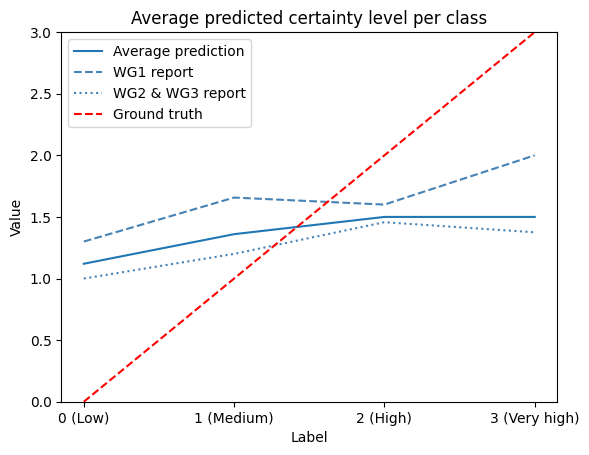

Macro F1 score: 0.25814494617358147
Weighted F1 score: 0.33137274874426237
Accuracy (total): 0.4
              precision    recall  f1-score   support

        high     0.4609    0.5300    0.4930       100
         low     0.5000    0.0200    0.0385        50
      medium     0.3591    0.6500    0.4626       100
   very high     0.5000    0.0200    0.0385        50

    accuracy                         0.4000       300
   macro avg     0.4550    0.3050    0.2581       300
weighted avg     0.4400    0.4000    0.3314       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.39
Average scores per category: {'low': 1.1, 'medium': 1.36, 'high': 1.52, 'very high': 1.48}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.6105263157894736
Average scores per category: {'low': 1.3, 'medium': 1.6857142857142857, 

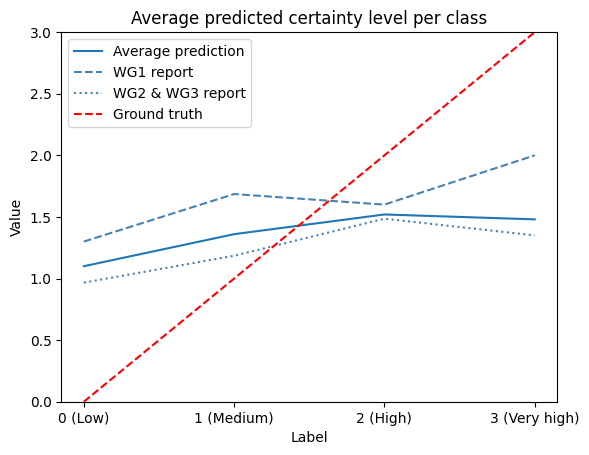

In [19]:
for n in range(1, 6): 
    model_classification_col_name=f"model_confidence_classification_{n}"
    get_metrics(original_prompt_experiment_df, model_classification_col_name)
    get_confidence_assessment(original_prompt_experiment_df, model_classification_col_name)

Macro F1 score: 0.22624688953802877
Weighted F1 score: 0.29525226297378193
Accuracy (total): 0.38666666666666666
              precision    recall  f1-score   support

        high     0.3981    0.8600    0.5443       100
         low     0.0000    0.0000    0.0000        50
      medium     0.3625    0.2900    0.3222       100
   very high     0.5000    0.0200    0.0385        50

    accuracy                         0.3867       300
   macro avg     0.3152    0.2925    0.2262       300
weighted avg     0.3369    0.3867    0.2953       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.7266666666666666
Average scores per category: {'low': 1.4, 'medium': 1.7, 'high': 1.85, 'very high': 1.86}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.8526315789473684
Average scores per category: {'low': 1.55, 

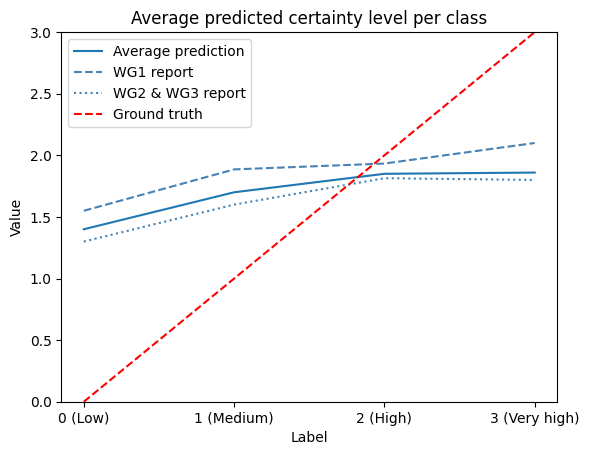

Macro F1 score: 0.24029288498230622
Weighted F1 score: 0.30757000048922883
Accuracy (total): 0.39666666666666667
              precision    recall  f1-score   support

        high     0.3991    0.8700    0.5472       100
         low     0.0000    0.0000    0.0000        50
      medium     0.3846    0.3000    0.3371       100
   very high     1.0000    0.0400    0.0769        50

    accuracy                         0.3967       300
   macro avg     0.4459    0.3025    0.2403       300
weighted avg     0.4279    0.3967    0.3076       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.7333333333333334
Average scores per category: {'low': 1.44, 'medium': 1.68, 'high': 1.86, 'very high': 1.88}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.8421052631578947
Average scores per category: {'low': 1.5,

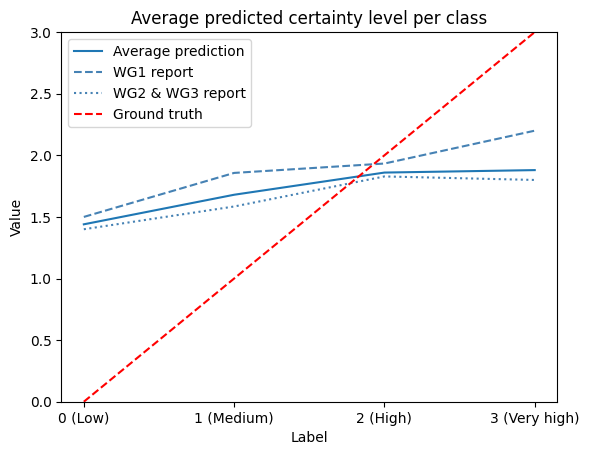

Macro F1 score: 0.24642574323085503
Weighted F1 score: 0.31004913912262155
Accuracy (total): 0.39666666666666667
              precision    recall  f1-score   support

        high     0.4085    0.8700    0.5559       100
         low     0.0000    0.0000    0.0000        50
      medium     0.3537    0.2900    0.3187       100
   very high     0.7500    0.0600    0.1111        50

    accuracy                         0.3967       300
   macro avg     0.3780    0.3050    0.2464       300
weighted avg     0.3790    0.3967    0.3100       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.7333333333333334
Average scores per category: {'low': 1.42, 'medium': 1.7, 'high': 1.87, 'very high': 1.84}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.8526315789473684
Average scores per category: {'low': 1.55,

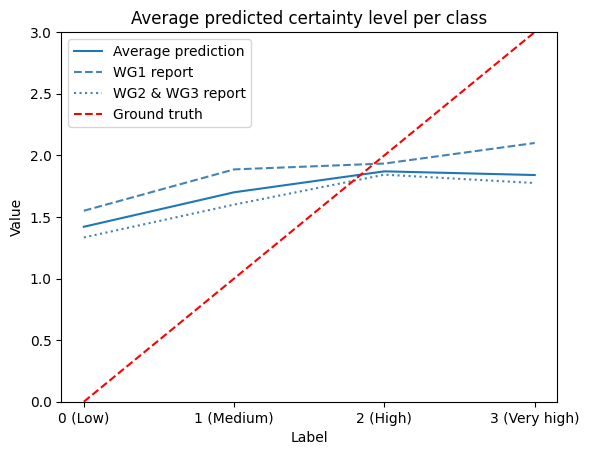

Macro F1 score: 0.242641048993508
Weighted F1 score: 0.31117571964566504
Accuracy (total): 0.4
              precision    recall  f1-score   support

        high     0.4104    0.8700    0.5577       100
         low     0.0000    0.0000    0.0000        50
      medium     0.3735    0.3100    0.3388       100
   very high     0.5000    0.0400    0.0741        50

    accuracy                         0.4000       300
   macro avg     0.3210    0.3050    0.2426       300
weighted avg     0.3446    0.4000    0.3112       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.73
Average scores per category: {'low': 1.42, 'medium': 1.69, 'high': 1.87, 'very high': 1.84}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.8526315789473684
Average scores per category: {'low': 1.55, 'medium': 1.8857142857142857, 

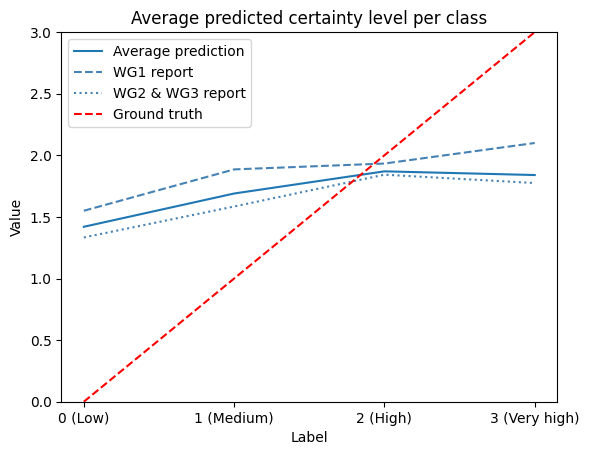

Macro F1 score: 0.24671360825633853
Weighted F1 score: 0.3163728613229168
Accuracy (total): 0.4033333333333333
              precision    recall  f1-score   support

        high     0.4135    0.8600    0.5584       100
         low     0.0000    0.0000    0.0000        50
      medium     0.3793    0.3300    0.3529       100
   very high     0.6667    0.0400    0.0755        50

    accuracy                         0.4033       300
   macro avg     0.3649    0.3075    0.2467       300
weighted avg     0.3754    0.4033    0.3164       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.7066666666666668
Average scores per category: {'low': 1.34, 'medium': 1.68, 'high': 1.85, 'very high': 1.84}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.831578947368421
Average scores per category: {'low': 1.5, 'm

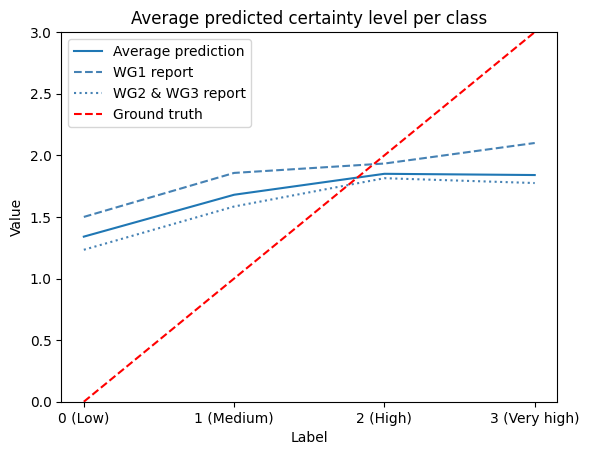

In [20]:
for n in range(1, 6): 
    model_classification_col_name=f"model_confidence_classification_{n}"
    get_metrics(manually_adjusted_prompt_experiment_df, model_classification_col_name)
    get_confidence_assessment(manually_adjusted_prompt_experiment_df, model_classification_col_name)

## Try again with GPT-4o

In [21]:
client = OpenAI()
model = "gpt-4o"

In [22]:
original_prompt_experiment_df = test_set.copy()
original_prompt_experiment_df = run_experiment(original_prompt_experiment_df, 5, get_original_prompt, model) 
original_prompt_experiment_df.to_csv("results/cleaned_dataset/gpt_4o_sc_original_prompt_03062024.csv")

/var/folders/zw/vnb4lkhd14n9cx0d71_qh_z00000gn/T/ipykernel_21596/250015384.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[[f"raw_output_{i}", f"model_confidence_classification_{i}", f"model_logprobs{i}"]] = dataset["final_statement"].apply(lambda x: query_openai_model(client, x, prompt_fn, model))


In [23]:
manually_adjusted_prompt_experiment_df = test_set.copy()
manually_adjusted_prompt_experiment_df = run_experiment(manually_adjusted_prompt_experiment_df, 5, get_refined_prompt, model) 
manually_adjusted_prompt_experiment_df.to_csv("results/cleaned_dataset/gpt_4o_sc_manually_adjusted_prompt_03062024.csv")

/var/folders/zw/vnb4lkhd14n9cx0d71_qh_z00000gn/T/ipykernel_21596/250015384.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[[f"raw_output_{i}", f"model_confidence_classification_{i}", f"model_logprobs{i}"]] = dataset["final_statement"].apply(lambda x: query_openai_model(client, x, prompt_fn, model))


In [24]:
manually_adjusted_prompt_experiment_df = pd.read_csv("results/cleaned_dataset/gpt_4o_sc_manually_adjusted_prompt_03062024.csv")
original_prompt_experiment_df = pd.read_csv("results/cleaned_dataset/gpt_4o_sc_original_prompt_03062024.csv")

Macro F1 score: 0.3403553343936683
Weighted F1 score: 0.3875127948949736
Accuracy (total): 0.42333333333333334
              precision    recall  f1-score   support

        high     0.4392    0.6500    0.5242       100
         low     0.6250    0.1000    0.1724        50
      medium     0.3984    0.4900    0.4395       100
   very high     0.3810    0.1600    0.2254        50

    accuracy                         0.4233       300
   macro avg     0.4609    0.3500    0.3404       300
weighted avg     0.4468    0.4233    0.3875       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.6066666666666667
Average scores per category: {'low': 1.08, 'medium': 1.48, 'high': 1.85, 'very high': 1.9}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.768421052631579
Average scores per category: {'low': 1.15, 'm

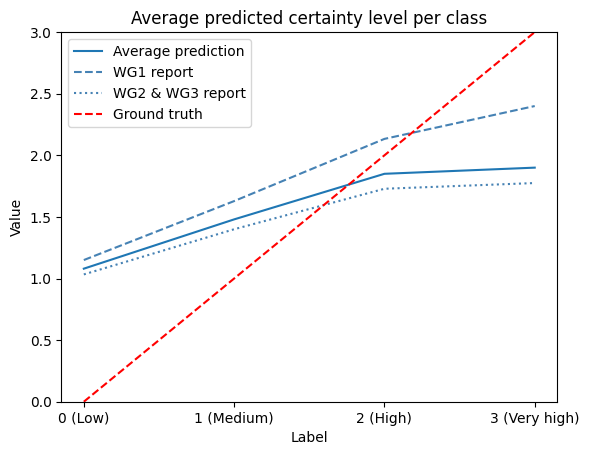

Macro F1 score: 0.36711699892187727
Weighted F1 score: 0.4133012090064533
Accuracy (total): 0.45
              precision    recall  f1-score   support

        high     0.4570    0.6900    0.5498       100
         low     0.7143    0.1000    0.1754        50
      medium     0.4215    0.5100    0.4615       100
   very high     0.4762    0.2000    0.2817        50

    accuracy                         0.4500       300
   macro avg     0.5172    0.3750    0.3671       300
weighted avg     0.4912    0.4500    0.4133       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.62
Average scores per category: {'low': 1.1, 'medium': 1.48, 'high': 1.85, 'very high': 1.96}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.768421052631579
Average scores per category: {'low': 1.2, 'medium': 1.6285714285714286, '

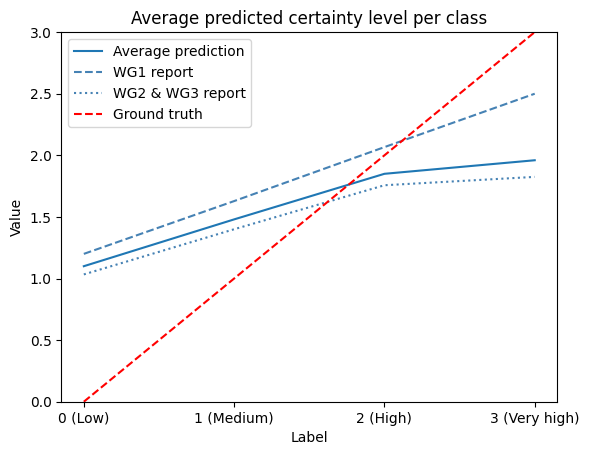

Macro F1 score: 0.3564232027814705
Weighted F1 score: 0.4026118894229131
Accuracy (total): 0.44
              precision    recall  f1-score   support

        high     0.4416    0.6800    0.5354       100
         low     0.8333    0.1000    0.1786        50
      medium     0.4167    0.5000    0.4545       100
   very high     0.4500    0.1800    0.2571        50

    accuracy                         0.4400       300
   macro avg     0.5354    0.3650    0.3564       300
weighted avg     0.5000    0.4400    0.4026       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.6266666666666667
Average scores per category: {'low': 1.1, 'medium': 1.5, 'high': 1.86, 'very high': 1.94}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.8
Average scores per category: {'low': 1.15, 'medium': 1.7428571428571429, 'h

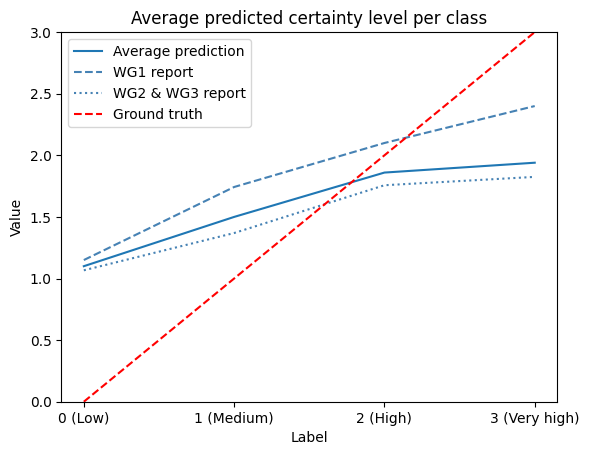

Macro F1 score: 0.33171951935838423
Weighted F1 score: 0.386552188850018
Accuracy (total): 0.43
              precision    recall  f1-score   support

        high     0.4459    0.6600    0.5323       100
         low     0.6000    0.0600    0.1091        50
      medium     0.4127    0.5200    0.4602       100
   very high     0.3810    0.1600    0.2254        50

    accuracy                         0.4300       300
   macro avg     0.4599    0.3500    0.3317       300
weighted avg     0.4497    0.4300    0.3866       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.6166666666666667
Average scores per category: {'low': 1.12, 'medium': 1.47, 'high': 1.86, 'very high': 1.92}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.8210526315789475
Average scores per category: {'low': 1.2, 'medium': 1.6857

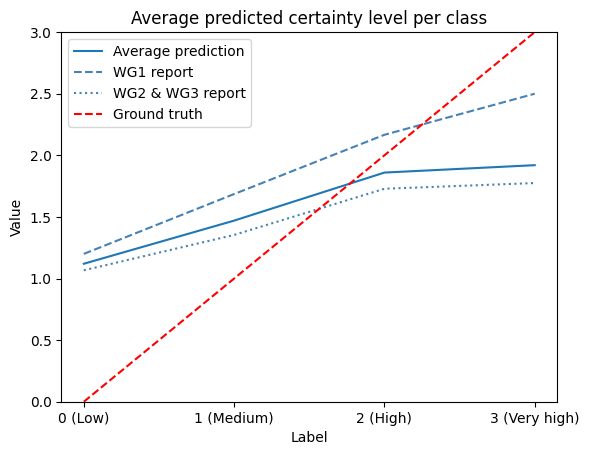

Macro F1 score: 0.3560393704945452
Weighted F1 score: 0.3998172941209013
Accuracy (total): 0.43333333333333335
              precision    recall  f1-score   support

        high     0.4422    0.6500    0.5263       100
         low     0.7143    0.1000    0.1754        50
      medium     0.4065    0.5000    0.4484       100
   very high     0.4348    0.2000    0.2740        50

    accuracy                         0.4333       300
   macro avg     0.4994    0.3625    0.3560       300
weighted avg     0.4744    0.4333    0.3998       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.62
Average scores per category: {'low': 1.1, 'medium': 1.49, 'high': 1.85, 'very high': 1.94}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.7894736842105263
Average scores per category: {'low': 1.15, 'medium': 1.657

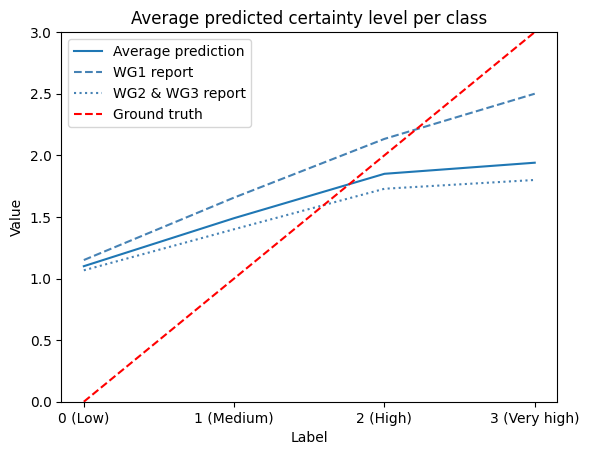

In [25]:
for n in range(1, 6): 
    model_classification_col_name=f"model_confidence_classification_{n}"
    get_metrics(original_prompt_experiment_df, model_classification_col_name)
    get_confidence_assessment(original_prompt_experiment_df, model_classification_col_name)

Macro F1 score: 0.3461870255348516
Weighted F1 score: 0.39368146614523425
Accuracy (total): 0.43666666666666665
              precision    recall  f1-score   support

        high     0.4261    0.7500    0.5435       100
         low     0.7500    0.0600    0.1111        50
      medium     0.4607    0.4100    0.4339       100
   very high     0.3871    0.2400    0.2963        50

    accuracy                         0.4367       300
   macro avg     0.5060    0.3650    0.3462       300
weighted avg     0.4851    0.4367    0.3937       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.78
Average scores per category: {'low': 1.18, 'medium': 1.6, 'high': 2.07, 'very high': 2.16}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.8526315789473684
Average scores per category: {'low': 1.15, 'medium': 1.74

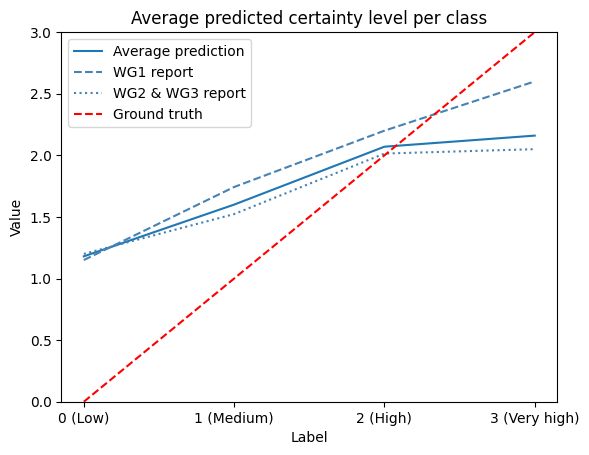

Macro F1 score: 0.3347660461628037
Weighted F1 score: 0.3864465294199839
Accuracy (total): 0.43666666666666665
              precision    recall  f1-score   support

        high     0.4368    0.7600    0.5547       100
         low     0.5000    0.0200    0.0385        50
      medium     0.4409    0.4100    0.4249       100
   very high     0.4194    0.2600    0.3210        50

    accuracy                         0.4367       300
   macro avg     0.4492    0.3625    0.3348       300
weighted avg     0.4458    0.4367    0.3864       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.78
Average scores per category: {'low': 1.2, 'medium': 1.6, 'high': 2.06, 'very high': 2.16}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.8421052631578947
Average scores per category: {'low': 1.15, 'medium': 1.7428

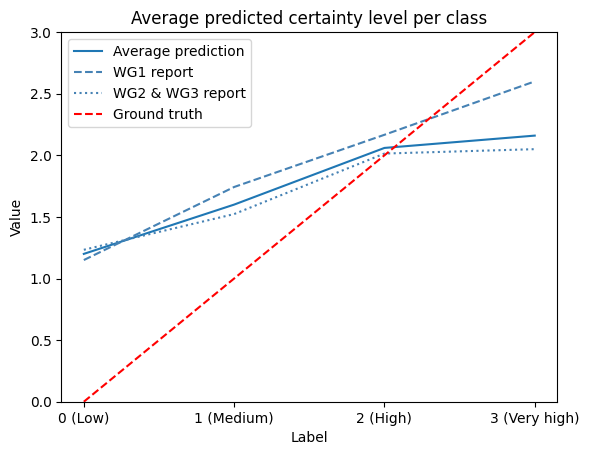

Macro F1 score: 0.3654450161350071
Weighted F1 score: 0.4118309338891331
Accuracy (total): 0.45666666666666667
              precision    recall  f1-score   support

        high     0.4438    0.7900    0.5683       100
         low     0.7500    0.0600    0.1111        50
      medium     0.4767    0.4100    0.4409       100
   very high     0.4375    0.2800    0.3415        50

    accuracy                         0.4567       300
   macro avg     0.5270    0.3850    0.3654       300
weighted avg     0.5048    0.4567    0.4118       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.7933333333333332
Average scores per category: {'low': 1.18, 'medium': 1.6, 'high': 2.09, 'very high': 2.2}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.8526315789473684
Average scores per category: {'low': 1.1, 'me

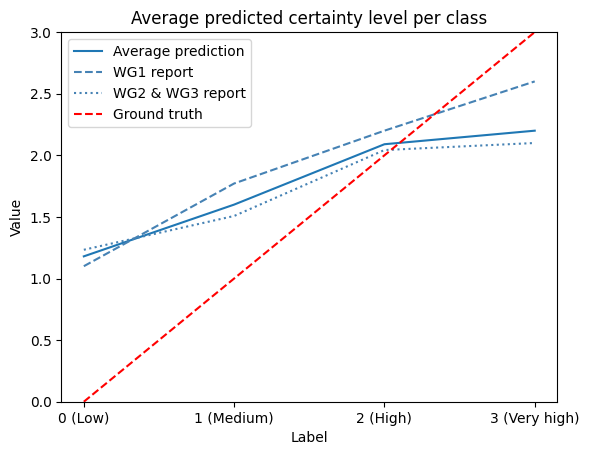

Macro F1 score: 0.3328940195606862
Weighted F1 score: 0.38040938485382936
Accuracy (total): 0.42333333333333334
              precision    recall  f1-score   support

        high     0.4229    0.7400    0.5382       100
         low     0.6000    0.0600    0.1091        50
      medium     0.4382    0.3900    0.4127       100
   very high     0.3548    0.2200    0.2716        50

    accuracy                         0.4233       300
   macro avg     0.4540    0.3525    0.3329       300
weighted avg     0.4462    0.4233    0.3804       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.7733333333333334
Average scores per category: {'low': 1.16, 'medium': 1.6, 'high': 2.08, 'very high': 2.12}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.8526315789473684
Average scores per category: {'low': 1.15, 

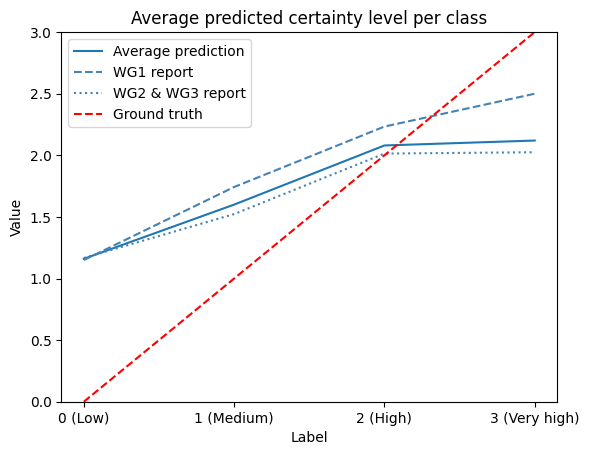

Macro F1 score: 0.35403545826932925
Weighted F1 score: 0.3993620925072538
Accuracy (total): 0.44666666666666666
              precision    recall  f1-score   support

        high     0.4444    0.8000    0.5714       100
         low     0.7500    0.0600    0.1111        50
      medium     0.4419    0.3800    0.4086       100
   very high     0.4333    0.2600    0.3250        50

    accuracy                         0.4467       300
   macro avg     0.5174    0.3750    0.3540       300
weighted avg     0.4927    0.4467    0.3994       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.7866666666666666
Average scores per category: {'low': 1.2, 'medium': 1.63, 'high': 2.06, 'very high': 2.14}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.8421052631578947
Average scores per category: {'low': 1.15, 

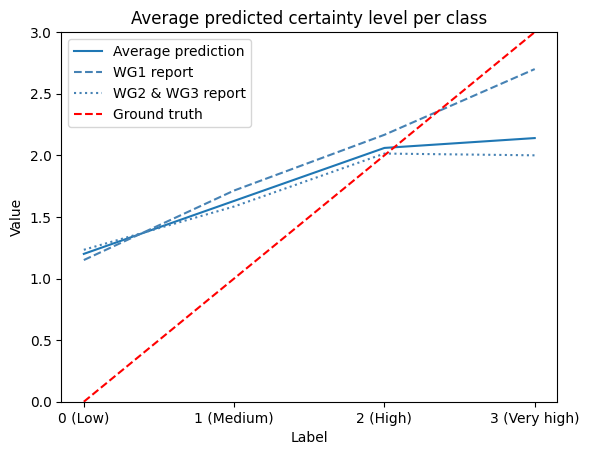

In [26]:
for n in range(1, 6): 
    model_classification_col_name=f"model_confidence_classification_{n}"
    get_metrics(manually_adjusted_prompt_experiment_df, model_classification_col_name)
    get_confidence_assessment(manually_adjusted_prompt_experiment_df, model_classification_col_name)

## With a less confidence-inducing prompt

In [27]:
def get_less_confident_prompt(statement):
    return f"""
You will be presented with a sentence about climate science, the impacts of climate change, or mitigation of climate change, retrieved or paraphrased from the 6th IPCC assessment report. 

This statement has been labeled as low, medium, high, or very high confidence by a consensus of climate experts, based on the type, quality, quantity, and consistency of scientific evidence available.

Respond *only* with one of the following words: 'low', 'medium', 'high', 'very high'.

Statement: {statement}
Confidence: """

### GPT3.5turbo

In [28]:
model = "gpt-3.5-turbo"

In [29]:

less_confident_prompt_experiment_df = test_set.copy()
less_confident_prompt_experiment_df = run_experiment(less_confident_prompt_experiment_df, 5, get_less_confident_prompt, model) 
less_confident_prompt_experiment_df.to_csv("results/cleaned_dataset/gpt_3.5_turbo_sc_less_confident_prompt_03062024.csv")

/var/folders/zw/vnb4lkhd14n9cx0d71_qh_z00000gn/T/ipykernel_21596/250015384.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[[f"raw_output_{i}", f"model_confidence_classification_{i}", f"model_logprobs{i}"]] = dataset["final_statement"].apply(lambda x: query_openai_model(client, x, prompt_fn, model))


In [30]:
less_confident_prompt_experiment_df.head()

,Unnamed: 0.1,Unnamed: 0,statement_idx,report,page_num,sent_num,original_statement,final_statement,confidence,score,...,model_logprobs2,raw_output_3,model_confidence_classification_3,model_logprobs3,raw_output_4,model_confidence_classification_4,model_logprobs4,raw_output_5,model_confidence_classification_5,model_logprobs5
3,3,0,3,AR6_WGI,24,2,"Since 1750, increases in CO 2 (47%) and CH 4 (...","Since 1750, increases in CO2 (47%) and CH4 (15...",very high,3,...,"[(very, -0.104517154, 90.08), (high, -2.623215...",very high,very high,"[(very, -0.104140945, 90.11), (Very, -2.679294...",very high,very high,"[(very, -0.3247569, 72.27), (Very, -1.8625815,...",very high,very high,"[(very, -0.2690393, 76.41), (high, -2.021231, ..."
42,42,1,42,AR6_WGI,37,16,"Over the next 2000 years, global mean sea leve...","Over the next 2000 years, global mean sea leve...",low,0,...,"[(high, -0.42529938, 65.36), (very, -1.2336051...",high,high,"[(high, -0.63103455, 53.2), (very, -0.8690488,...",high,high,"[(high, -0.7519598, 47.14), (very, -0.7545252,...",high,high,"[(high, -0.66605824, 51.37), (very, -0.9095656..."
77,77,2,77,AR6_WGI,47,7,"By the end of the century, scenarios with very...","By the end of the century, scenarios with very...",high,2,...,"[(high, -0.14063762, 86.88), (High, -2.686416,...",high,high,"[(high, -0.121075235, 88.6), (High, -2.9502168...",high,high,"[(high, -0.13215022, 87.62), (High, -2.5396762...",high,high,"[(high, -0.0548078, 94.67), (very, -3.5717852,..."
81,81,3,81,AR6_WGI,62,2,"Over the past millennium, and especially since...","Over the past millennium, and especially since...",medium,1,...,"[(high, -0.22484547, 79.86), (High, -2.1359763...",high,high,"[(high, -0.13238521, 87.6), (medium, -2.591661...",high,high,"[(high, -0.14037918, 86.9), (medium, -2.521894...",high,high,"[(high, -0.33323786, 71.66), (High, -1.8348897..."
86,86,4,86,AR6_WGI,63,8,This paleo context supports the assessment tha...,The paleo context supports the assessment that...,high,2,...,"[(high, -0.63526654, 52.98), (very, -1.3627408...",high,high,"[(high, -0.70465946, 49.43), (very, -1.2008486...",high,high,"[(high, -0.3408027, 71.12), (very, -1.4998107,...",high,high,"[(high, -0.63526654, 52.98), (very, -1.3627408..."


Macro F1 score: 0.23876225945876442
Weighted F1 score: 0.3060040002660069
Accuracy (total): 0.4
              precision    recall  f1-score   support

        high     0.4036    0.9000    0.5573       100
         low     0.0000    0.0000    0.0000        50
      medium     0.3836    0.2800    0.3237       100
   very high     0.5000    0.0400    0.0741        50

    accuracy                         0.4000       300
   macro avg     0.3218    0.3050    0.2388       300
weighted avg     0.3457    0.4000    0.3060       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.77
Average scores per category: {'low': 1.42, 'medium': 1.73, 'high': 1.9, 'very high': 1.94}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.8526315789473684
Average scores per category: {'low': 1.55, 'medium': 1.8857142857142857, 

/Users/kerriewu/opt/anaconda3/envs/climate-llms/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kerriewu/opt/anaconda3/envs/climate-llms/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kerriewu/opt/anaconda3/envs/climate-llms/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

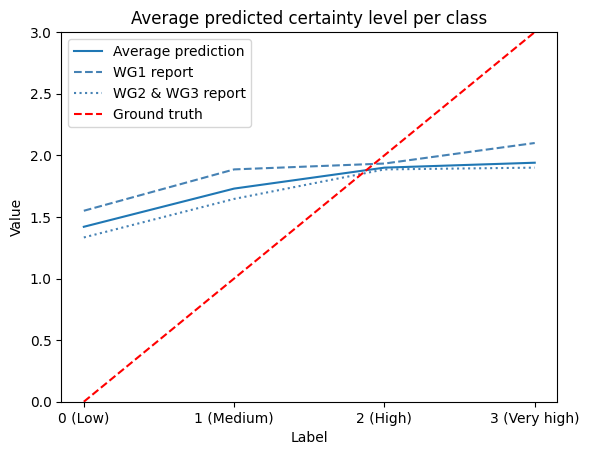

Macro F1 score: 0.24522635229961104
Weighted F1 score: 0.30844995121429625
Accuracy (total): 0.4
              precision    recall  f1-score   support

        high     0.3982    0.9000    0.5521       100
         low     0.0000    0.0000    0.0000        50
      medium     0.3857    0.2700    0.3176       100
   very high     0.7500    0.0600    0.1111        50

    accuracy                         0.4000       300
   macro avg     0.3835    0.3075    0.2452       300
weighted avg     0.3863    0.4000    0.3084       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.78
Average scores per category: {'low': 1.44, 'medium': 1.74, 'high': 1.9, 'very high': 1.96}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.831578947368421
Average scores per category: {'low': 1.5, 'medium': 1.8571428571428572, '

/Users/kerriewu/opt/anaconda3/envs/climate-llms/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kerriewu/opt/anaconda3/envs/climate-llms/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kerriewu/opt/anaconda3/envs/climate-llms/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

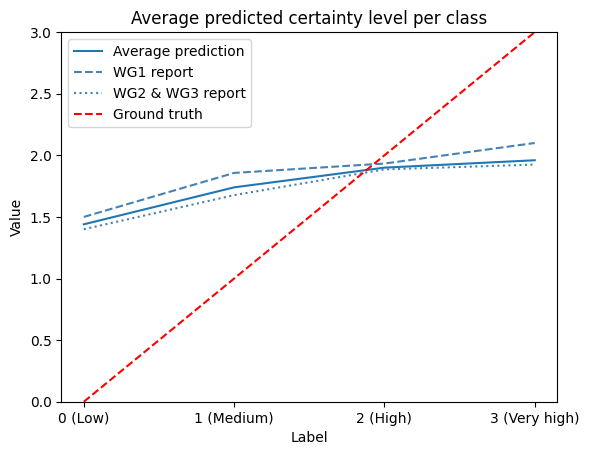

Macro F1 score: 0.24669168751737558
Weighted F1 score: 0.31074043184134925
Accuracy (total): 0.4
              precision    recall  f1-score   support

        high     0.3921    0.8900    0.5443       100
         low     0.0000    0.0000    0.0000        50
      medium     0.4118    0.2800    0.3333       100
   very high     0.6000    0.0600    0.1091        50

    accuracy                         0.4000       300
   macro avg     0.3510    0.3075    0.2467       300
weighted avg     0.3679    0.4000    0.3107       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.79
Average scores per category: {'low': 1.5, 'medium': 1.73, 'high': 1.91, 'very high': 1.96}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.8736842105263158
Average scores per category: {'low': 1.55, 'medium': 1.9142857142857144,

/Users/kerriewu/opt/anaconda3/envs/climate-llms/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kerriewu/opt/anaconda3/envs/climate-llms/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kerriewu/opt/anaconda3/envs/climate-llms/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

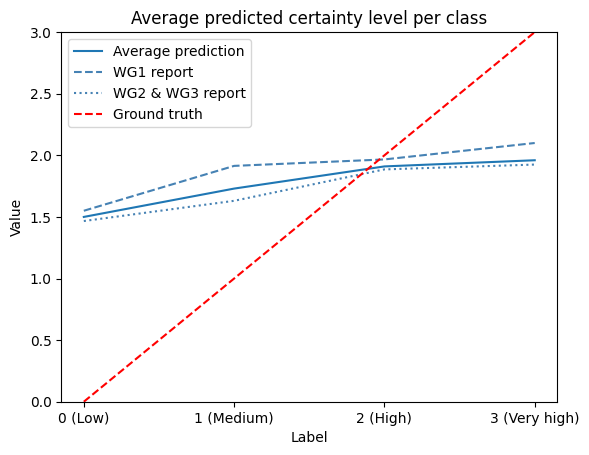

Macro F1 score: 0.24837882307394504
Weighted F1 score: 0.3126532455800749
Accuracy (total): 0.4066666666666667
              precision    recall  f1-score   support

        high     0.4035    0.9200    0.5610       100
         low     0.0000    0.0000    0.0000        50
      medium     0.3971    0.2700    0.3214       100
   very high     0.7500    0.0600    0.1111        50

    accuracy                         0.4067       300
   macro avg     0.3876    0.3125    0.2484       300
weighted avg     0.3919    0.4067    0.3127       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.7866666666666666
Average scores per category: {'low': 1.46, 'medium': 1.74, 'high': 1.92, 'very high': 1.94}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.8526315789473684
Average scores per category: {'low': 1.55, 

/Users/kerriewu/opt/anaconda3/envs/climate-llms/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kerriewu/opt/anaconda3/envs/climate-llms/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kerriewu/opt/anaconda3/envs/climate-llms/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

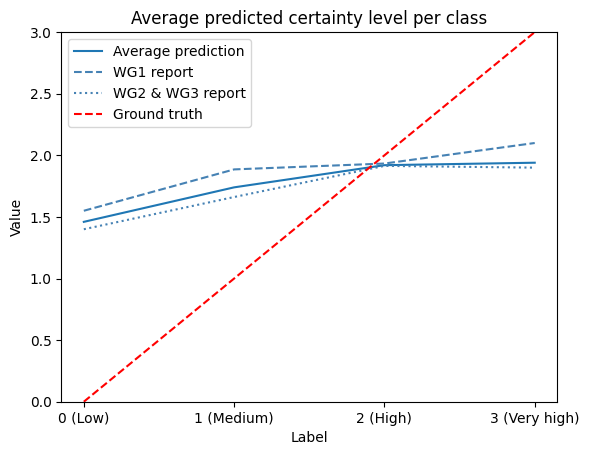

Macro F1 score: 0.24811066126855602
Weighted F1 score: 0.3122956965062228
Accuracy (total): 0.4033333333333333
              precision    recall  f1-score   support

        high     0.4000    0.9000    0.5538       100
         low     0.0000    0.0000    0.0000        50
      medium     0.3944    0.2800    0.3275       100
   very high     0.7500    0.0600    0.1111        50

    accuracy                         0.4033       300
   macro avg     0.3861    0.3100    0.2481       300
weighted avg     0.3898    0.4033    0.3123       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.7766666666666666
Average scores per category: {'low': 1.46, 'medium': 1.73, 'high': 1.9, 'very high': 1.94}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.8421052631578947
Average scores per category: {'low': 1.5, 'm

/Users/kerriewu/opt/anaconda3/envs/climate-llms/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kerriewu/opt/anaconda3/envs/climate-llms/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kerriewu/opt/anaconda3/envs/climate-llms/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

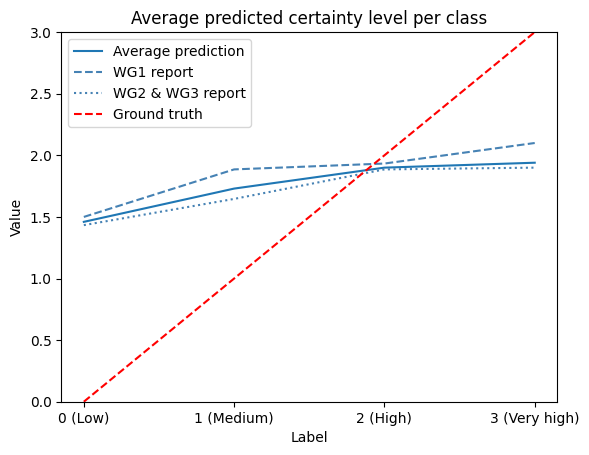

In [31]:
for n in range(1, 6): 
    model_classification_col_name=f"model_confidence_classification_{n}"
    get_metrics(less_confident_prompt_experiment_df, model_classification_col_name)
    get_confidence_assessment(less_confident_prompt_experiment_df, model_classification_col_name)

### GPT4o

In [32]:
model = "gpt-4o"
less_confident_prompt_experiment_df = test_set.copy()
less_confident_prompt_experiment_df = run_experiment(less_confident_prompt_experiment_df, 5, get_less_confident_prompt, model) 
less_confident_prompt_experiment_df.to_csv("results/cleaned_dataset/gpt_4o_sc_less_confident_prompt_03062024.csv")

/var/folders/zw/vnb4lkhd14n9cx0d71_qh_z00000gn/T/ipykernel_21596/250015384.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[[f"raw_output_{i}", f"model_confidence_classification_{i}", f"model_logprobs{i}"]] = dataset["final_statement"].apply(lambda x: query_openai_model(client, x, prompt_fn, model))


Macro F1 score: 0.33805520888854224
Weighted F1 score: 0.37299991188880083
Accuracy (total): 0.42
              precision    recall  f1-score   support

        high     0.4082    0.8000    0.5405       100
         low     0.8000    0.0800    0.1455        50
      medium     0.4265    0.2900    0.3452       100
   very high     0.4194    0.2600    0.3210        50

    accuracy                         0.4200       300
   macro avg     0.5135    0.3575    0.3381       300
weighted avg     0.4814    0.4200    0.3730       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.8433333333333333
Average scores per category: {'low': 1.18, 'medium': 1.72, 'high': 2.1, 'very high': 2.24}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.8526315789473684
Average scores per category: {'low': 1.15, 'medium': 1.8,

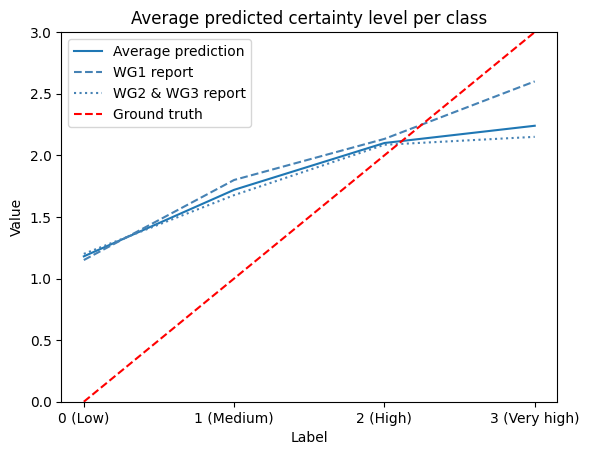

Macro F1 score: 0.3404153302844293
Weighted F1 score: 0.3736401934656588
Accuracy (total): 0.42333333333333334
              precision    recall  f1-score   support

        high     0.4080    0.8200    0.5449       100
         low     1.0000    0.0800    0.1481        50
      medium     0.4179    0.2800    0.3353       100
   very high     0.4643    0.2600    0.3333        50

    accuracy                         0.4233       300
   macro avg     0.5725    0.3600    0.3404       300
weighted avg     0.5193    0.4233    0.3736       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.8433333333333333
Average scores per category: {'low': 1.18, 'medium': 1.73, 'high': 2.1, 'very high': 2.22}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.8736842105263158
Average scores per category: {'low': 1.15, '

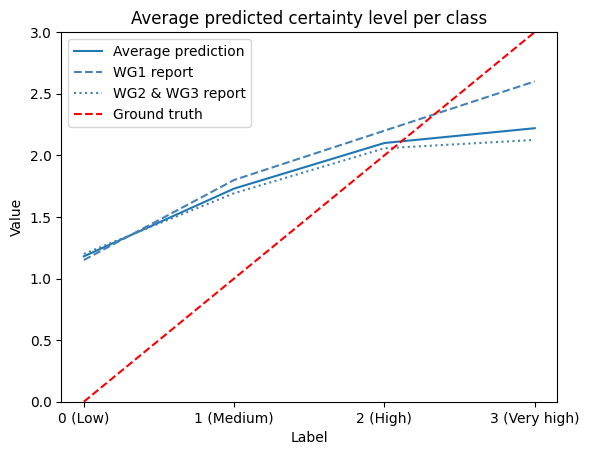

Macro F1 score: 0.3535793700120404
Weighted F1 score: 0.38465971139449995
Accuracy (total): 0.43333333333333335
              precision    recall  f1-score   support

        high     0.4158    0.8400    0.5563       100
         low     0.8333    0.1000    0.1786        50
      medium     0.4242    0.2800    0.3373       100
   very high     0.5000    0.2600    0.3421        50

    accuracy                         0.4333       300
   macro avg     0.5434    0.3700    0.3536       300
weighted avg     0.5023    0.4333    0.3847       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.8266666666666667
Average scores per category: {'low': 1.16, 'medium': 1.71, 'high': 2.08, 'very high': 2.22}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.8631578947368421
Average scores per category: {'low': 1.15,

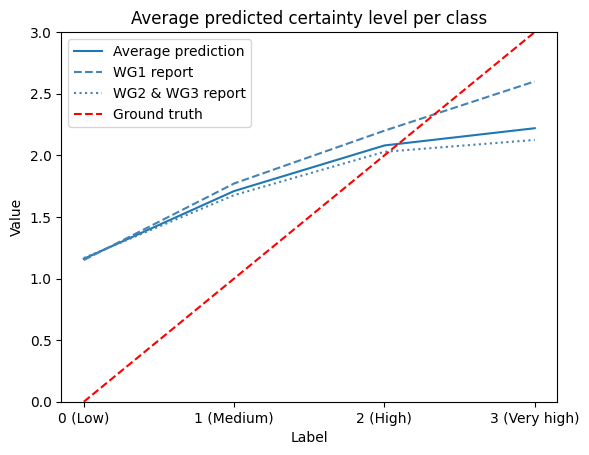

Macro F1 score: 0.3357047376228962
Weighted F1 score: 0.3709669068577849
Accuracy (total): 0.42
              precision    recall  f1-score   support

        high     0.4070    0.8100    0.5418       100
         low     1.0000    0.0800    0.1481        50
      medium     0.4143    0.2900    0.3412       100
   very high     0.4444    0.2400    0.3117        50

    accuracy                         0.4200       300
   macro avg     0.5664    0.3550    0.3357       300
weighted avg     0.5145    0.4200    0.3710       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.83
Average scores per category: {'low': 1.16, 'medium': 1.73, 'high': 2.07, 'very high': 2.22}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.8736842105263158
Average scores per category: {'low': 1.15, 'medium': 1.8, 'high': 2.2, '

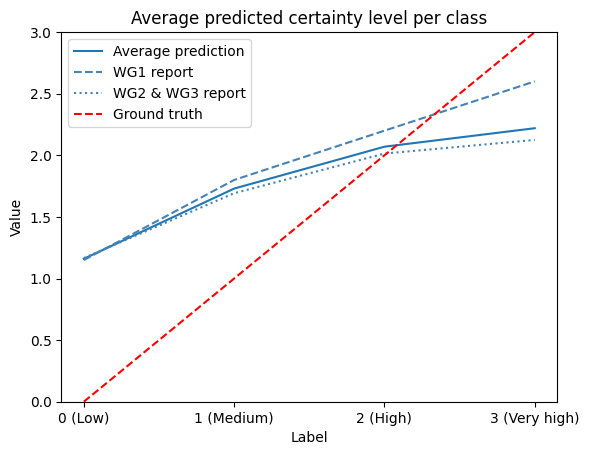

Macro F1 score: 0.336672923779194
Weighted F1 score: 0.36980248678806227
Accuracy (total): 0.42
              precision    recall  f1-score   support

        high     0.4080    0.8200    0.5449       100
         low     0.8000    0.0800    0.1455        50
      medium     0.4154    0.2700    0.3273       100
   very high     0.4483    0.2600    0.3291        50

    accuracy                         0.4200       300
   macro avg     0.5179    0.3575    0.3367       300
weighted avg     0.4825    0.4200    0.3698       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.8466666666666667
Average scores per category: {'low': 1.2, 'medium': 1.74, 'high': 2.08, 'very high': 2.24}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.894736842105263
Average scores per category: {'low': 1.15, 'medium': 1.85714

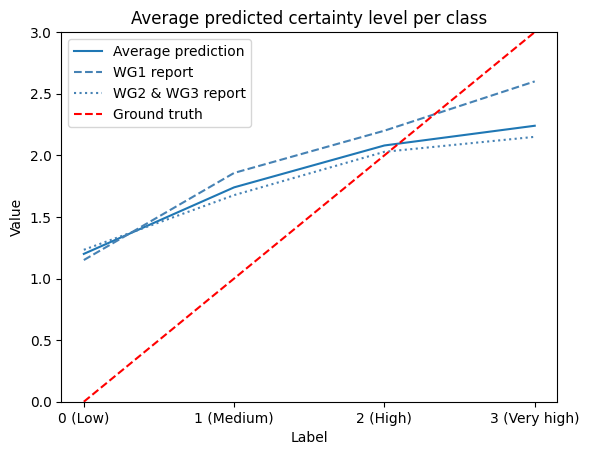

In [33]:
for n in range(1, 6): 
    model_classification_col_name=f"model_confidence_classification_{n}"
    get_metrics(less_confident_prompt_experiment_df, model_classification_col_name)
    get_confidence_assessment(less_confident_prompt_experiment_df, model_classification_col_name)